<center><img src="https://github.com/hse-ds/iad-applied-ds/raw/2025/homeworks/HW1/img/logo_hse.png" width="1000"></center>

<h1><center>Прикладные задачи анализа данных</center></h1>
<h2><center>Домашнее задание 1: Генеративные сети</center></h2>

# Введение

Не все же нам MNIST генерировать. Давайте посмотрим, как генеративные модели могут использоваться не только для развлечения. Поехали!

Немного вступления и мотивации, для чего мы хотим обучать модель.

## MAGIC – Major Atmospheric Gamma Imaging Cherenkov Telescope

MAGIC (Major Atmospheric Gamma Imaging Cherenkov) - это система, состоящая из двух черенковских телескопов диаметром 17 м. Они предназначены для наблюдения гамма-лучей от галактических и внегалактических источников в диапазоне очень высоких энергий (от 30 ГэВ до 100 ТэВ).

MAGIC позволил открыть и исследовать новые классы источников гамма-излучения, таких как, например, пульсары и гамма-всплески (GRB).

<center><img src="https://github.com/hse-ds/iad-applied-ds/raw/2025/homeworks/HW1/img/magic1.jpg" width="1000"></center>

Источник: https://magic.mpp.mpg.de/

Youtube video: https://youtu.be/mjcDSR2vSU8

#### Ок, давайте зафиксируем. Какой-то крутой телескоп позволяет открыть новые виды излучения. Идем дальше.

## Частицы из космоса

Космические частицы, $\gamma$-кванты (фотоны) и адроны (протоны), взаимодействуют с атмосферой и порождают ливни вторичных частиц. Двигаясь с околосветовой скоростью, эти частицы излучают Черенковское излучение. Телескопы фотографируют это излучение.
#### По фотографиям можно определить тип частицы из космоса: фотон или протон. Знакомая формулировка задачи, не правда ли?

<center><img src="https://github.com/hse-ds/iad-applied-ds/raw/2025/homeworks/HW1/img/shower.jpg" width="500"></center>

## Фотографии

Задача атмосферного черенковского телескопа - получить изображение ливня путем измерения черенковского света от частиц ливня. Это изображение представляет собой геометрическую проекцию ливня на детектор. Для анализа этих изображений были введены параметры изображения или так называемые параметры Хилласа. Ниже пример такой фотографии.

<center><img src="https://github.com/hse-ds/iad-applied-ds/raw/2025/homeworks/HW1/img/geo.jpg" width="400"></center>

#### Итак, каждая фотография описывается набором параметров, которые за нас считает телескоп. А что там с двумя видами частиц?

## Фотоны vs адронов

Изображения для $\gamma$-квантов (фотонов) и адронов (протонов) отличаются по форме кластеров. Астрономы используют модели машинного обучения для классификации этих изображений. Получение каждого такого изображения - дорогое удовольствие!


<center><img src="https://github.com/hse-ds/iad-applied-ds/raw/2025/homeworks/HW1/img/gamma_p.png" width="600"></center>

Для обучения моделей ученые искусственно генерируют такие изображения для каждого типа частиц с помощью сложных физических симуляторов.

#### Итак, давайте сэкономим денег для ученых и сгенерируем хороших фотографий разных частиц. Используем для этого GAN и диффузионные модели!

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Данные

Будем использовать данные телескопа MAGIC из UCI репозитория https://archive.ics.uci.edu/ml/datasets/MAGIC+Gamma+Telescope. Каждый объект в данных - параметры одного изображения кластера и метка этого кластера (фотон или адрон):


0. Length: major axis of ellipse [mm]
1. Width: minor axis of ellipse [mm]
2. Size: 10-log of sum of content of all pixels [in #phot]
3. Conc: ratio of sum of two highest pixels over fSize [ratio]
4. Conc1: ratio of highest pixel over fSize [ratio]
5. Asym: distance from highest pixel to center, projected onto major axis [mm]
6. M3Long: 3rd root of third moment along major axis [mm]
7. M3Trans: 3rd root of third moment along minor axis [mm]
8. Alpha: angle of major axis with vector to origin [deg]
9. Dist: distance from origin to center of ellipse [mm]
10. class: g,h # gamma (signal), hadron (background)

In [4]:
# read data
names = np.array(
    [
        "Length",
        "Width",
        "Size",
        "Conc",
        "Conc1",
        "Asym",
        "M3Long",
        "M3Trans",
        "Alpha",
        "Dist",
        "class",
    ]
)
data = pd.read_csv("data/magic04.data", header=None)
data.columns = names
print(data.shape)
data.head()

(19020, 11)


,Length,Width,Size,Conc,Conc1,Asym,M3Long,M3Trans,Alpha,Dist,class
0,28.7967,16.0021,2.6449,0.3918,0.1982,27.7004,22.0110,-8.2027,40.0920,81.8828,g
1,31.6036,11.7235,2.5185,0.5303,0.3773,26.2722,23.8238,-9.9574,6.3609,205.2610,g
2,162.0520,136.0310,4.0612,0.0374,0.0187,116.7410,-64.8580,-45.2160,76.9600,256.7880,g
3,23.8172,9.5728,2.3385,0.6147,0.3922,27.2107,-6.4633,-7.1513,10.4490,116.7370,g
4,75.1362,30.9205,3.1611,0.3168,0.1832,-5.5277,28.5525,21.8393,4.6480,356.4620,g


# Постановка задачи

Ваша задача заключается в том, чтобы с помощью генеративно-состязательных сетей научиться генерировать параметры кластеров на изображениях телескопа для каждого типа частиц (фотона или адрона):

- $X$ - матрица реальных объектов, которые нужно начиться генерировать;
- $y$ - метки классов, которые будем использовать как условие при генерации.

In [5]:
# параметры кластеров на изображениях
X = data[names[:-1]].values
X = np.abs(X)

# метки классов
labels = data[names[-1]].values
y = np.ones((len(labels), 1))
y[labels == "h"] = 0

In [6]:
# примеры
X[:2]

array([[2.87967e+01, 1.60021e+01, 2.64490e+00, 3.91800e-01, 1.98200e-01,
        2.77004e+01, 2.20110e+01, 8.20270e+00, 4.00920e+01, 8.18828e+01],
       [3.16036e+01, 1.17235e+01, 2.51850e+00, 5.30300e-01, 3.77300e-01,
        2.62722e+01, 2.38238e+01, 9.95740e+00, 6.36090e+00, 2.05261e+02]])

In [7]:
# примеры
y[:10]

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.]])

In [8]:
# все возможные значения
np.unique(y)

array([0., 1.])

# Визуализация данных

Каждое изображение описывается 10 параметрами. Давайте построим распределения значений каждого параметра для каждого типа частиц.

In [9]:
def plot_hists(X1, X2, names, label1, label2, bins=np.linspace(-3, 3, 61)):
    plt.figure(figsize=(5 * 4, 5 * 2))
    for i in range(X1.shape[1]):
        plt.subplot(3, 4, i + 1)
        plt.grid()
        plt.hist(X1[:, i], bins=bins, alpha=0.3, label=label1, color="C4")
        plt.hist(X2[:, i], bins=bins, alpha=0.3, label=label2, color="C0")
        plt.xlabel(names[i], size=14)
        plt.legend(loc="best")
    plt.tight_layout()

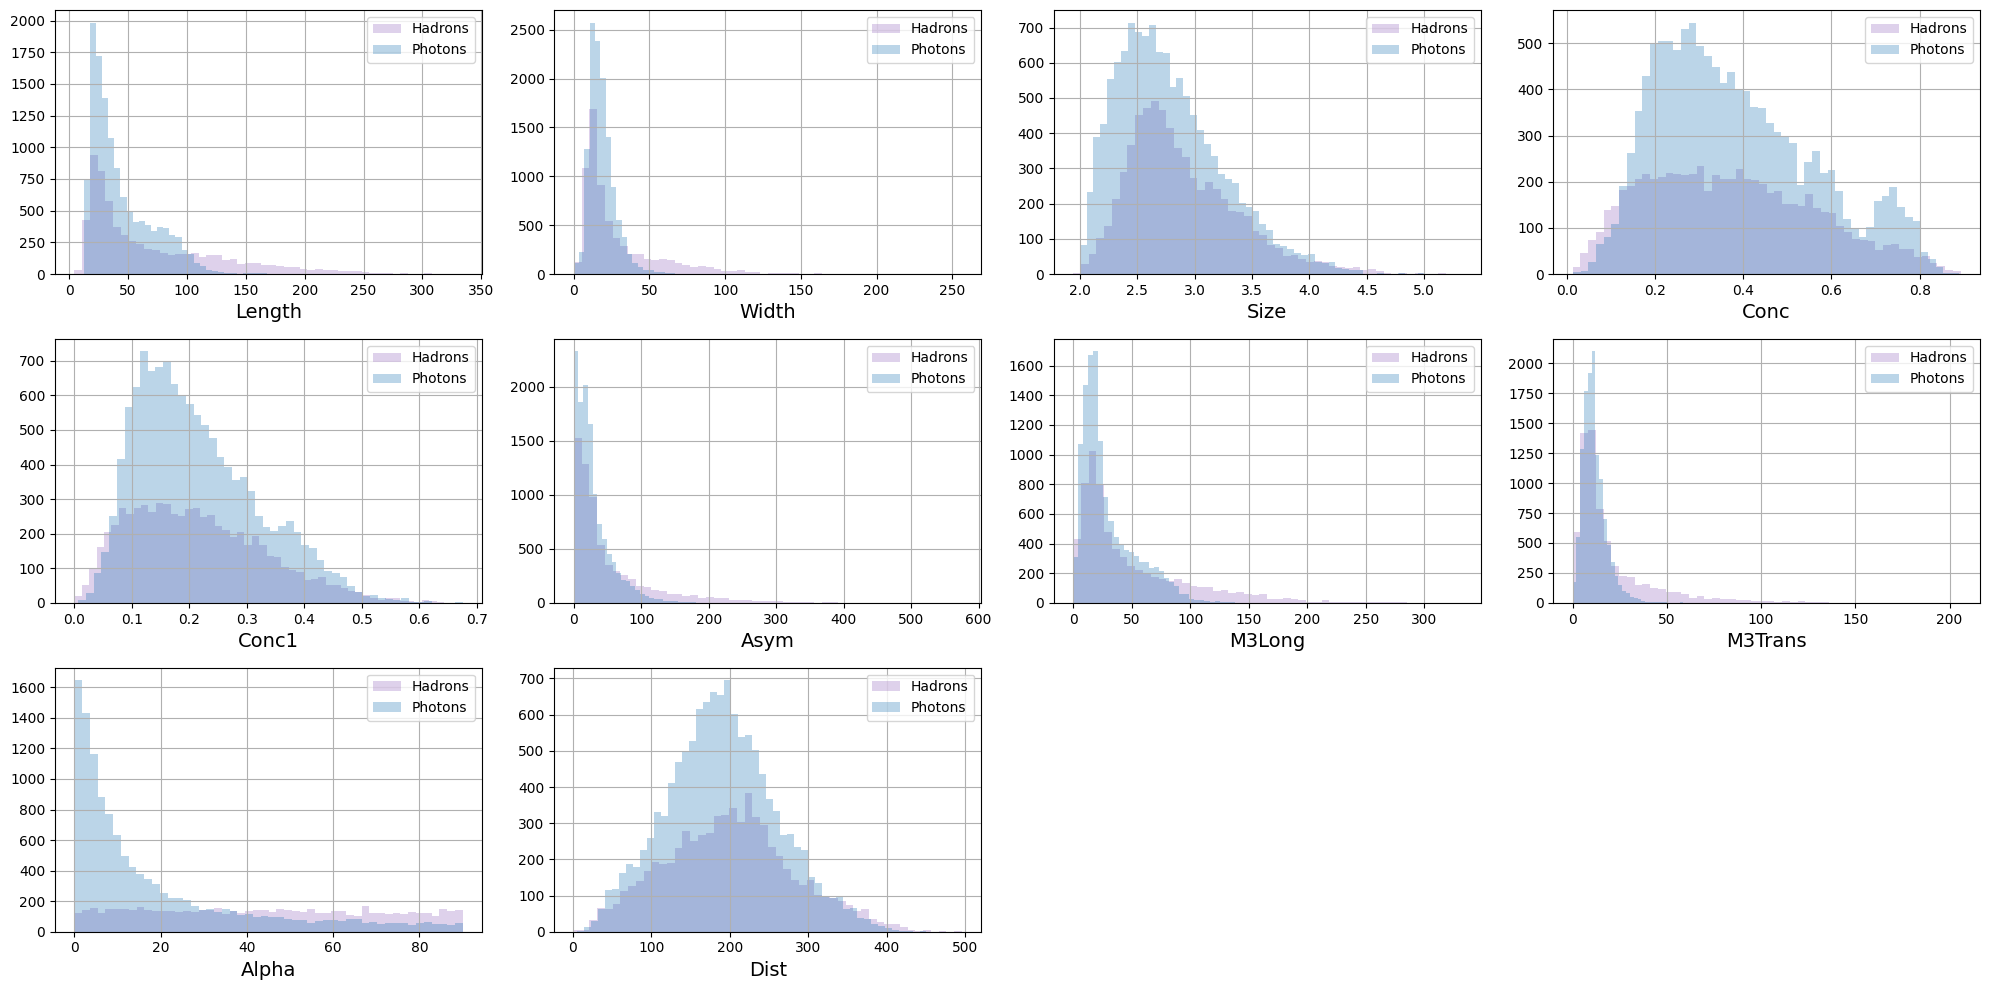

In [10]:
plot_hists(
    X[y[:, 0] == 0], X[y[:, 0] == 1], names, label1="Hadrons", label2="Photons", bins=50
)

# Предобработка данных

Из графика видим, что распределения для многих признаков имеют тяжелые хвосты. Это делает обучение генеративных моделей тяжелее. Поэтому нужно как-то преобразовать данные, чтобы убрать эти тяжелые хвосты.

# Обучающая и тестовая выборки

In [11]:
from sklearn.model_selection import train_test_split

# train / test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.5, shuffle=True, random_state=11
)

## Задание 1 (0.2 балла)

Проиллюстрируйте распределение целевой переменной внутри train и test выборки. Совпадает ли оно? Есть ли идеи почему так?

__Подсказка__: посмотрите на клеточку с разделением данных

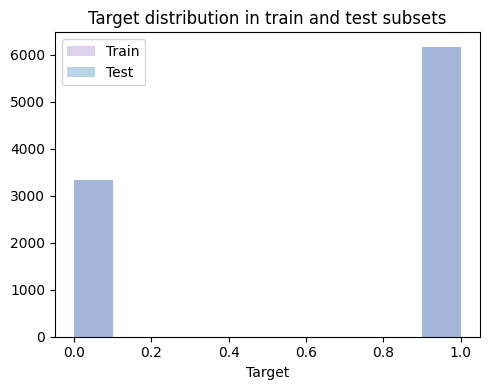


Train distribution
Hadrons: 3344 
Photons: 6166

Test distribution
Hadrons: 3344 
Photons: 6166


In [12]:
plt.figure(figsize=(5, 4))

plt.hist(y_train, bins=10, alpha=0.3, label="Train", color='C4')
plt.hist(y_test, bins=10, alpha=0.3, label="Test", color='C0')
plt.legend(loc="best")
plt.xlabel('Target')
plt.title('Target distribution in train and test subsets')

plt.tight_layout()
plt.show()

print("\nTrain distribution\nHadrons:", y_train[y_train[:, 0] == 0].size, "\nPhotons:", y_train[y_train[:, 0] == 1].size)
print("\nTest distribution\nHadrons:", y_test[y_test[:, 0] == 0].size, "\nPhotons:", y_test[y_test[:, 0] == 1].size)

**Вывод:** Распределения таргета в обучающей и тестовой выборках совпадают (буквально наславиваются на графике). Это связано с использованием параметра stratify в train_test_split со значением y, т.е. мы буквально указываем, что хотим иметь сбалансированное разделение по таргету. Кроме того, в разделении мы еще указали, что размеры обучающей и тестовой выборки должны совпадать (test_size = 0.5).

## Задание 2 (0.8 балл)

Используя функцию `sklearn.preprocessing.QuantileTransformer` трансформируйте входные данные `X_train` и `X_test`. Это преобразование делает так, чтобы распределение каждого параметра было нормальным. Описание функции доступно по [ссылке](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.QuantileTransformer.html). Используйте значение параметра `output_distribution='normal'`.

In [13]:
from sklearn.preprocessing import QuantileTransformer

qt = QuantileTransformer(output_distribution="normal", random_state=42)

X_train = qt.fit_transform(X_train)
X_test = qt.transform(X_test)

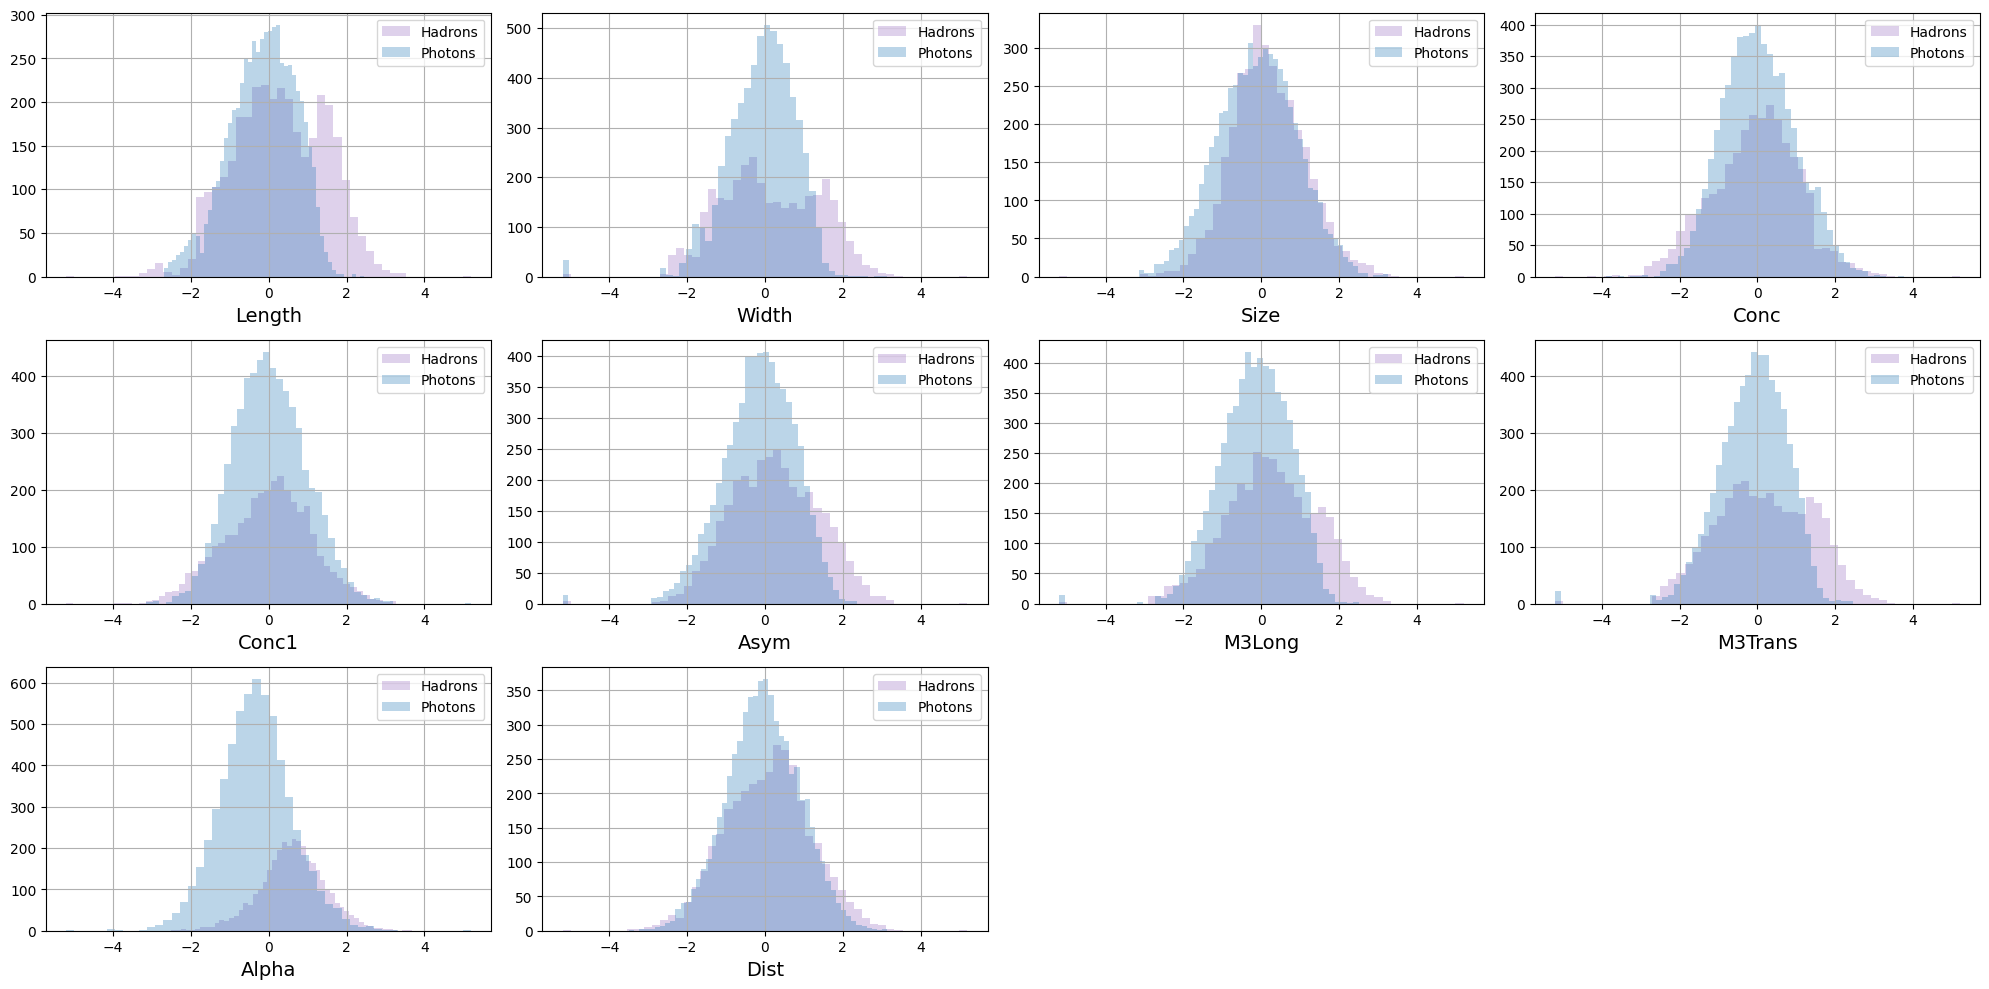

In [14]:
plot_hists(
    X_train[y_train[:, 0] == 0],
    X_train[y_train[:, 0] == 1],
    names,
    label1="Hadrons",
    label2="Photons",
    bins=50,
)

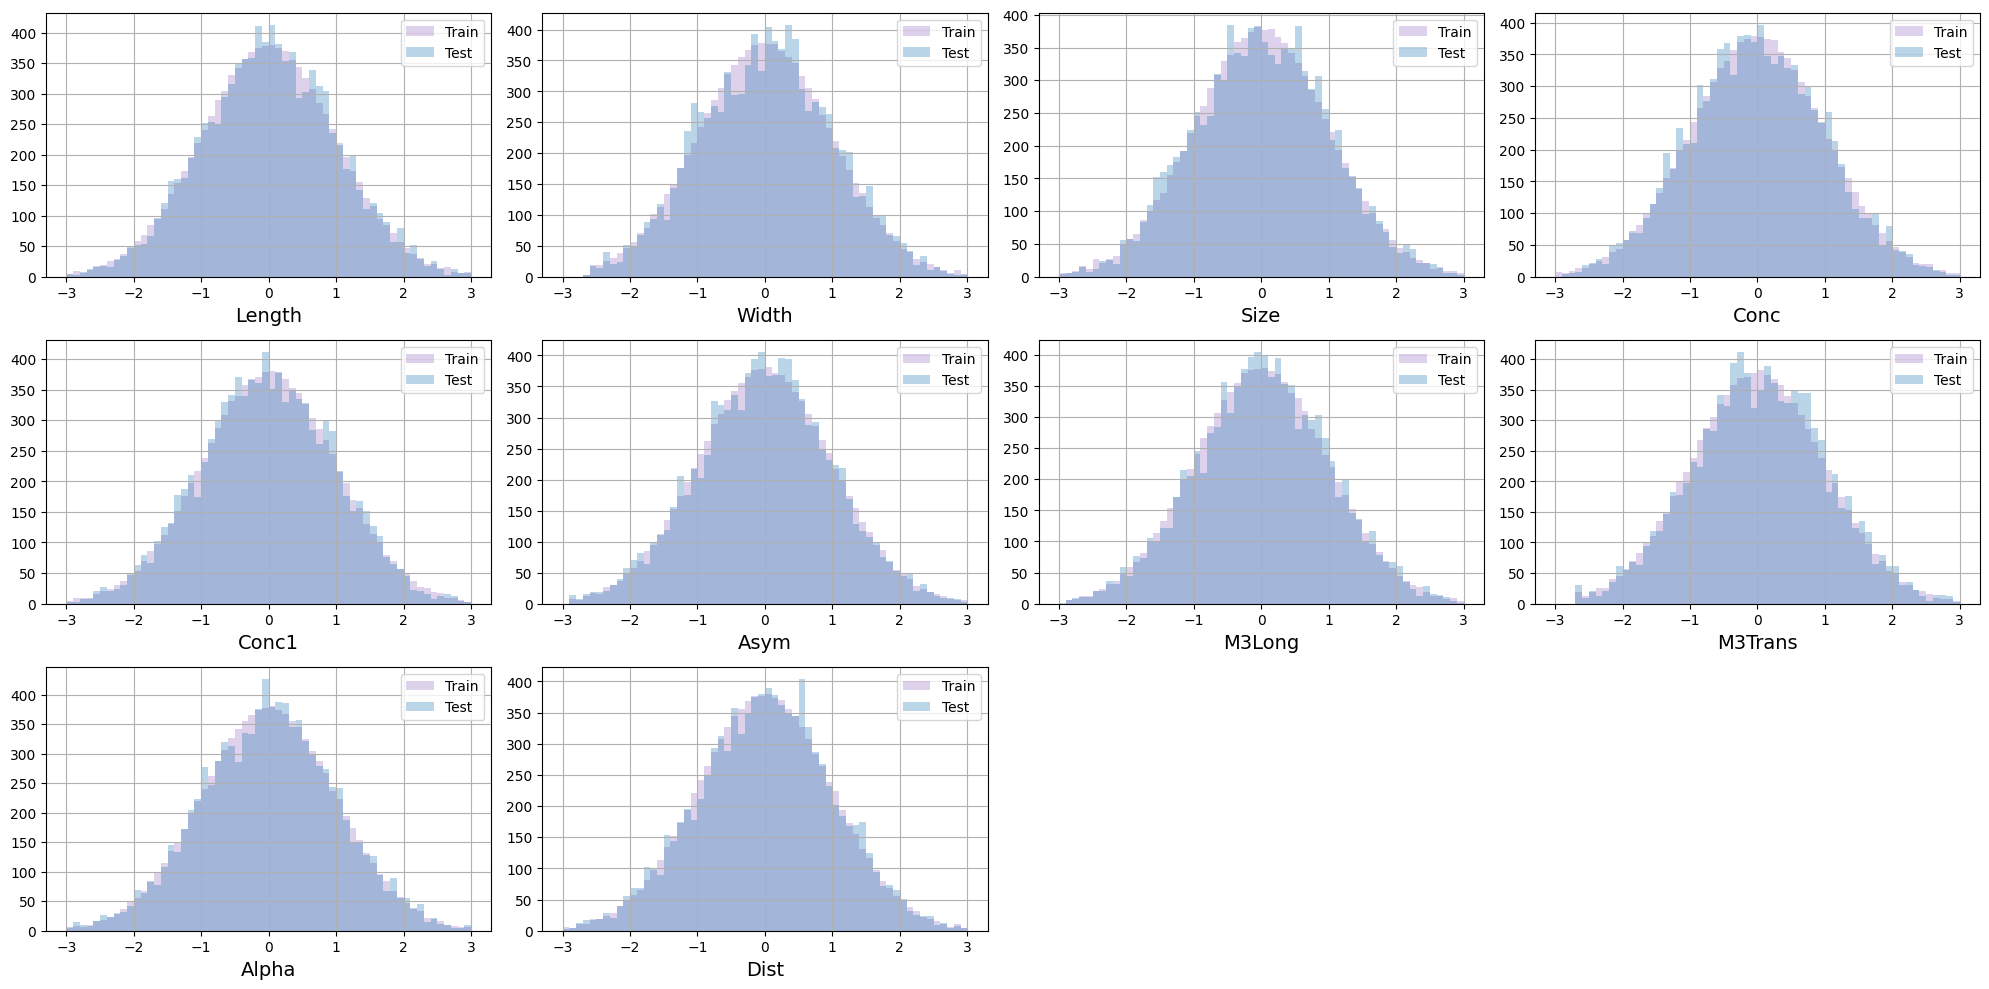

In [15]:
plot_hists(X_train, X_test, names, label1="Train", label2="Test")

# Conditional WGAN

Мы будем использовать `Conditional WGAN`, который изображен на рисунке. В качестве условия `y` мы будем использовать метку класса: **0** - адрон, **1** - фотон. Таким образом, мы будем сообщать генератору для какой частицы нужно генерировать параметры изображения.

<center><img src="https://github.com/hse-ds/iad-applied-ds/raw/2025/homeworks/HW1/img/cgan.png" width="800"></center>

Генератор $\hat{x} = G(z, y)$ будет принимать на вход шумовой вектор $z$ и вектор условий $y$, а выдавать будет сгенерированный (фейковый) вектор параметров $\hat{x}$.

Дискриминатор $D(x, y)$ будет принимать на вход вектор параметров $x$ и вектор условий $y$, а возвращать будет рациональное число.

Обучать `Conditional WGAN` будем с такой функцией потерь:

$$L(G, D) = -\frac{1}{n} \sum_{x_i \in X, y_i \in y} D(x_i, y_i) + \frac{1}{n} \sum_{z_i \in Z, y_i \in y} D(G(z_i, y_i), y_i) \to \max_G \min_D$$

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [17]:
DEVICE

device(type='cuda')

## Задание 3 (0.75 балла)

Реализуйте нейронную сеть для генератора со следующими слоями:
- Полносвязный слой со 100 нейронами;
- Слой батч-нормализации;
- ReLU функцию активации;
- Полносвязный слой со 100 нейронами;
- Слой батч-нормализации;
- ReLU функцию активации;
- Выходной слой.

In [18]:
class Generator(nn.Module):
    def __init__(self, n_inputs, n_outputs):
        super(Generator, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(n_inputs, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(),
            nn.Linear(100, n_outputs),
        )

    def forward(self, z, y):
        zy = torch.cat((z, y), dim=1)
        return self.net(zy)

## Задание 4 (0.5 балл)

Реализуйте функцию для генерации новых объектов $X$ по вектору условий $y$.

In [19]:
def generate(generator, y, latent_dim):
    y = torch.tensor(y, dtype=torch.float32).to(DEVICE)
    # Задаем шумовой вектор z.
    z = torch.normal(0, 1, (y.shape[0], latent_dim)).to(DEVICE)
    X_fake = generator(z, y)
    return X_fake.detach().cpu().numpy()  # numpy

## Задание 5 (0.75 балла)

Реализуйте нейронную сеть для дискриминатора со следующими слоями:
- Полносвязный слой со 100 нейронами;
- ReLU функцию активации;
- Полносвязный слой со 100 нейронами;
- ReLU функцию активации;
- Выходной слой.

Какая функция активации должна быть в конце работы модели и почему? А она вообще тут должна быть? Обоснуйте свой выбор.

In [20]:
class Discriminator(nn.Module):
    def __init__(self, n_inputs):
        super(Discriminator, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(n_inputs, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 1),
            nn.Sigmoid()
        )

    def forward(self, x, y):
        xy = torch.cat((x, y), dim=1)
        return self.net(xy)

По логике на выходе дискриминатора нужно добавить функцию активации Сигмоида, так как мы хотим, чтобы эта модель, решала задачу бинарной классификации: ее выход должен представлять вероятность принадлежности к одному из двух классов (фейк / не фейк).

## Задание 6 (0.5 балла)

Реализуйте функцию, которая принимала бы на вход набор сгенерированных и настоящих объектов, разбивала на train и test с учетом баланса классов (real и fake объектов), с соотношением 3 к 1, обучала модель логистической регрессии и градиентного бустинга, которые учились бы отличать настоящие объекты от фальшивых, после чего выводила бы accuracy score на отложенной выборке у обоих моделей.

Ответьте на вопрос: какое значение accuracy score нас бы удовлетворило больше всего? Почему?

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score

def other_agent_score(X_real, y_real, X_fake, y_fake):

    X_total = np.concatenate((X_real, X_fake))
    y_total = np.concatenate((y_real, y_fake))
    X_total = np.concatenate((X_total, y_total), axis=1)

    # Для баланса классов (real/fake) указываем их для использования в stratify.
    tmp_real = np.ones((len(y_real), 1))
    tmp_fake = np.zeros((len(y_fake), 1))
    tmp_total = np.concatenate((tmp_real, tmp_fake))

    X_train, X_test, y_train, y_test = train_test_split(X_total, tmp_total.flatten(), test_size=0.25, stratify=tmp_total, random_state=42)

    log_reg = LogisticRegression(random_state=42)
    log_reg.fit(X_train, y_train)
    y_pred_log_reg = log_reg.predict(X_test)
    log_reg_score = accuracy_score(y_test, y_pred_log_reg)

    # Обучение модели градиентного бустинга
    boosting_model = GradientBoostingClassifier(random_state=42)
    boosting_model.fit(X_train, y_train)
    y_pred_boosting = boosting_model.predict(X_test)
    boosting_score = accuracy_score(y_test, y_pred_boosting)

    print("Logistic regression score: " + str(log_reg_score))
    print("Boosting score: " + str(boosting_score))

**Ответ:** в принципе, нас устроит accuracy 0.6 - 0.7, так как в таком случае наш дискриминатор не будет слишком сильным, чтобы четко видеть фейки (мы в таком случае не сможем нормально обучить генератор), но и не будет заниматься случайным угадыванием.

## Задание 7 (1.5 балла)

Реализуйте класс для обучения генеративной модели.

- Уточнение 1: Нужно ограничивать веса дискриминатора. Для этого используйте `p.data.clamp_(-0.01, 0.01)`, где `p` веса дискриминатора. Зачем это делать можно посмотреть в оригинальной статье <https://arxiv.org/pdf/1701.07875.pdf>.
- Подсказка 1: `n_critic` - число итераций обучения дискриминатора на одну итерацию обучения генератора.
- Подсказка 2: Используйте `X_tensor = torch.tensor(X_numpy, dtype=torch.float, device=DEVICE)` для перевода numpy в тензор.

In [22]:
class Fitter(object):
    def __init__(
        self,
        generator,
        discriminator,
        batch_size=32,
        n_epochs=10,
        latent_dim=1,
        lr=0.0001,
        n_critic=5,
    ):

        self.generator = generator
        self.discriminator = discriminator
        self.batch_size = batch_size
        self.n_epochs = n_epochs
        self.latent_dim = latent_dim
        self.lr = lr
        self.n_critic = n_critic

        self.opt_gen = torch.optim.RMSprop(self.generator.parameters(), lr=self.lr)
        self.opt_disc = torch.optim.RMSprop(self.discriminator.parameters(), lr=self.lr)

        self.generator.to(DEVICE)
        self.discriminator.to(DEVICE)

    def fit(self, X, y):

        # numpy to tensor
        X_real = torch.tensor(X, dtype=torch.float, device=DEVICE)
        y_cond = torch.tensor(y, dtype=torch.float, device=DEVICE)

        # tensor to dataset
        dataset_real = TensorDataset(X_real, y_cond)

        # Turn on training
        self.generator.train(True)
        self.discriminator.train(True)

        self.loss_history = []

        # Fit GAN
        for epoch in range(self.n_epochs):
            for i, (real_batch, cond_batch) in enumerate(
                DataLoader(dataset_real, batch_size=self.batch_size, shuffle=True)
            ):

                real_batch = real_batch.to(DEVICE)
                cond_batch = cond_batch.to(DEVICE)

                # Генерация фейковых данных
                z = torch.normal(0, 1, (real_batch.size(0), self.latent_dim)).to(DEVICE)
                fake_batch = self.generator(z, cond_batch)

                # Считаем скоры
                real_objects_scores, gen_objects_scores = torch.split(
                    self.discriminator(torch.cat([real_batch, fake_batch], dim = 0), torch.cat([cond_batch, cond_batch], dim = 0)),
                    real_batch.size(0),
                )

                if (i % (1 + self.n_critic)) < 1: # Обучение генератора
                    self.opt_gen.zero_grad()

                    # Расчет потерь для генератора
                    loss_gen = -torch.mean(gen_objects_scores)
                    loss_gen.backward()
                    self.opt_gen.step()
                else:                             # Обучение дискриминатора
                    self.opt_disc.zero_grad()

                    # Расчет потерь для дискриминатора
                    loss_disc = -torch.mean(real_objects_scores) + torch.mean(gen_objects_scores)
                    loss_disc.backward()
                    self.opt_disc.step()

                    # Ограничение весов дискриминатора
                    for p in self.discriminator.parameters():
                        p.data.clamp_(-0.01, 0.01)


            # calculate and store loss after an epoch
            z = torch.normal(0, 1, (len(X_real), self.latent_dim)).to(DEVICE)
            X_fake = self.generator(z, y_cond)
            loss_epoch = torch.mean(self.discriminator(X_real, y_cond)) - torch.mean(
                self.discriminator(X_fake, y_cond)
            )
            self.loss_history.append(loss_epoch.detach().cpu())

            # Создайте выборку из 1000 объектов из X_train и 1000 сгенерированных объектов
            # И запустите работу функции other_agent_score

            if epoch % 10 == 0:
                num_samples = 1000
                indices = np.random.choice(len(X_real), num_samples)
                other_agent_score(X_real[indices].detach().cpu(), y_cond[indices].detach().cpu(), X_fake[indices].detach().cpu(), y_cond[indices].detach().cpu())


        # Turn off training
        self.generator.train(False)
        self.discriminator.train(False)


## Обучение
Обучим модель на данных.

In [23]:
%%time
latent_dim = 10
generator = Generator(n_inputs=latent_dim + y.shape[1], n_outputs=X_train.shape[1])
discriminator = Discriminator(n_inputs=X_train.shape[1] + y.shape[1])

fitter = Fitter(
    generator,
    discriminator,
    batch_size=50,
    n_epochs=100,
    latent_dim=latent_dim,
    lr=0.0001,
    n_critic=5,
)
fitter.fit(X_train, y_train)

Logistic regression score: 0.698
Boosting score: 0.966
Logistic regression score: 0.594
Boosting score: 0.804
Logistic regression score: 0.502
Boosting score: 0.662
Logistic regression score: 0.514
Boosting score: 0.698
Logistic regression score: 0.554
Boosting score: 0.666
Logistic regression score: 0.534
Boosting score: 0.592
Logistic regression score: 0.488
Boosting score: 0.614
Logistic regression score: 0.522
Boosting score: 0.57
Logistic regression score: 0.534
Boosting score: 0.572
Logistic regression score: 0.526
Boosting score: 0.562
CPU times: user 1min 13s, sys: 2.55 s, total: 1min 15s
Wall time: 1min 23s


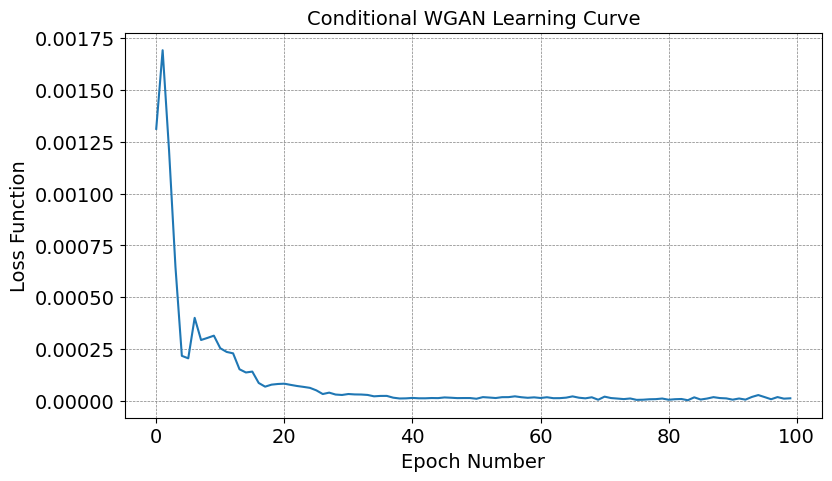

In [24]:
# WGAN learning curve
plt.figure(figsize=(9, 5))
plt.plot(fitter.loss_history)
plt.xlabel("Epoch Number", size=14)
plt.ylabel("Loss Function", size=14)
plt.xticks(size=14)
plt.yticks(size=14)
plt.title("Conditional WGAN Learning Curve", size=14)
plt.grid(visible=True, linestyle="--", linewidth=0.5, color="0.5")
plt.show()

## Задание 8 (0.5 балла)

Теперь сгенерируем фейковые матрицы `X_fake_train` и `X_fake_test`. Сравним их с матрицами реальных объектов `X_train` и `X_test`. Перед сравнением результатов сделайте обратное квантильное преобразование с помощью трансформера, который вы обучили в задании 2.

In [25]:
X_train_inv = qt.inverse_transform(X_train)
X_test_inv = qt.inverse_transform(X_test)

In [26]:
X_fake_train = generate(fitter.generator, y_train, latent_dim)
X_fake_train_inv = qt.inverse_transform(X_fake_train)

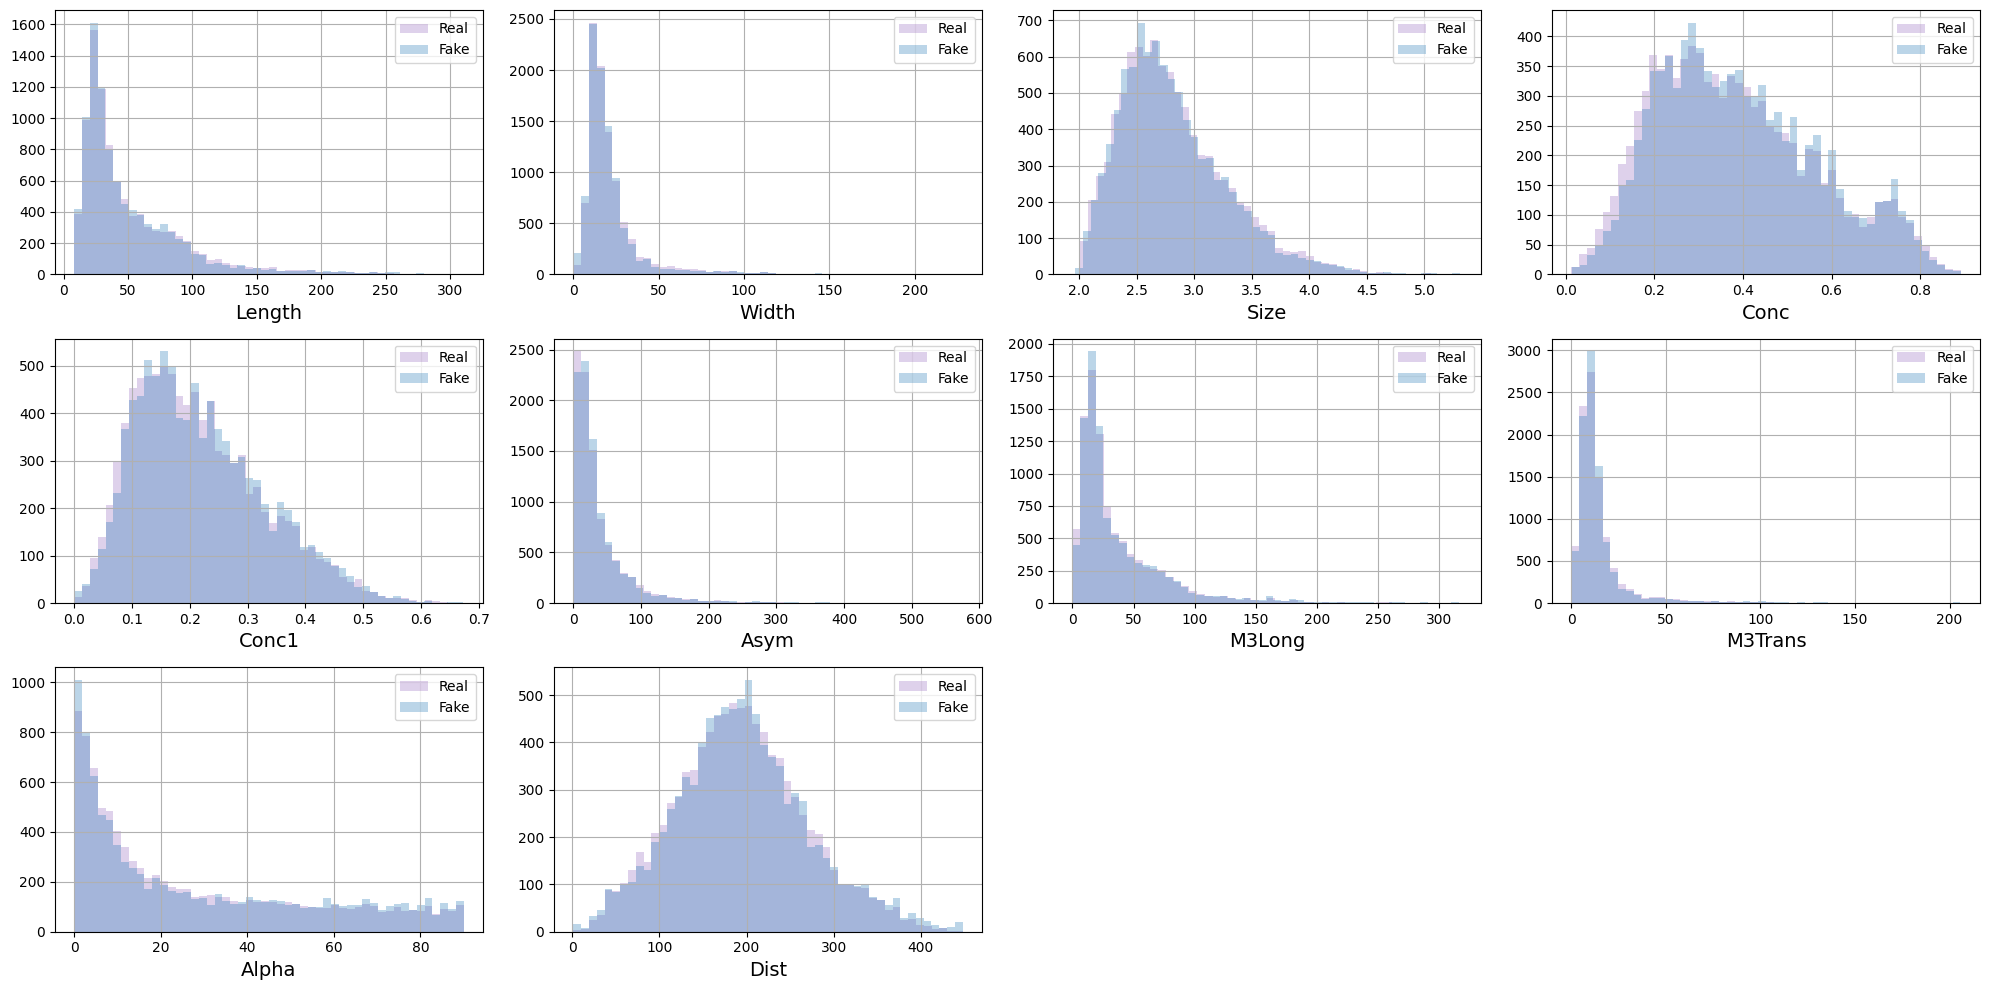

In [27]:
plot_hists(X_train_inv, X_fake_train_inv, names, label1="Real", label2="Fake", bins=50)

In [28]:
X_fake_test = generate(fitter.generator, y_test, latent_dim)
X_fake_test_inv = qt.inverse_transform(X_fake_test)

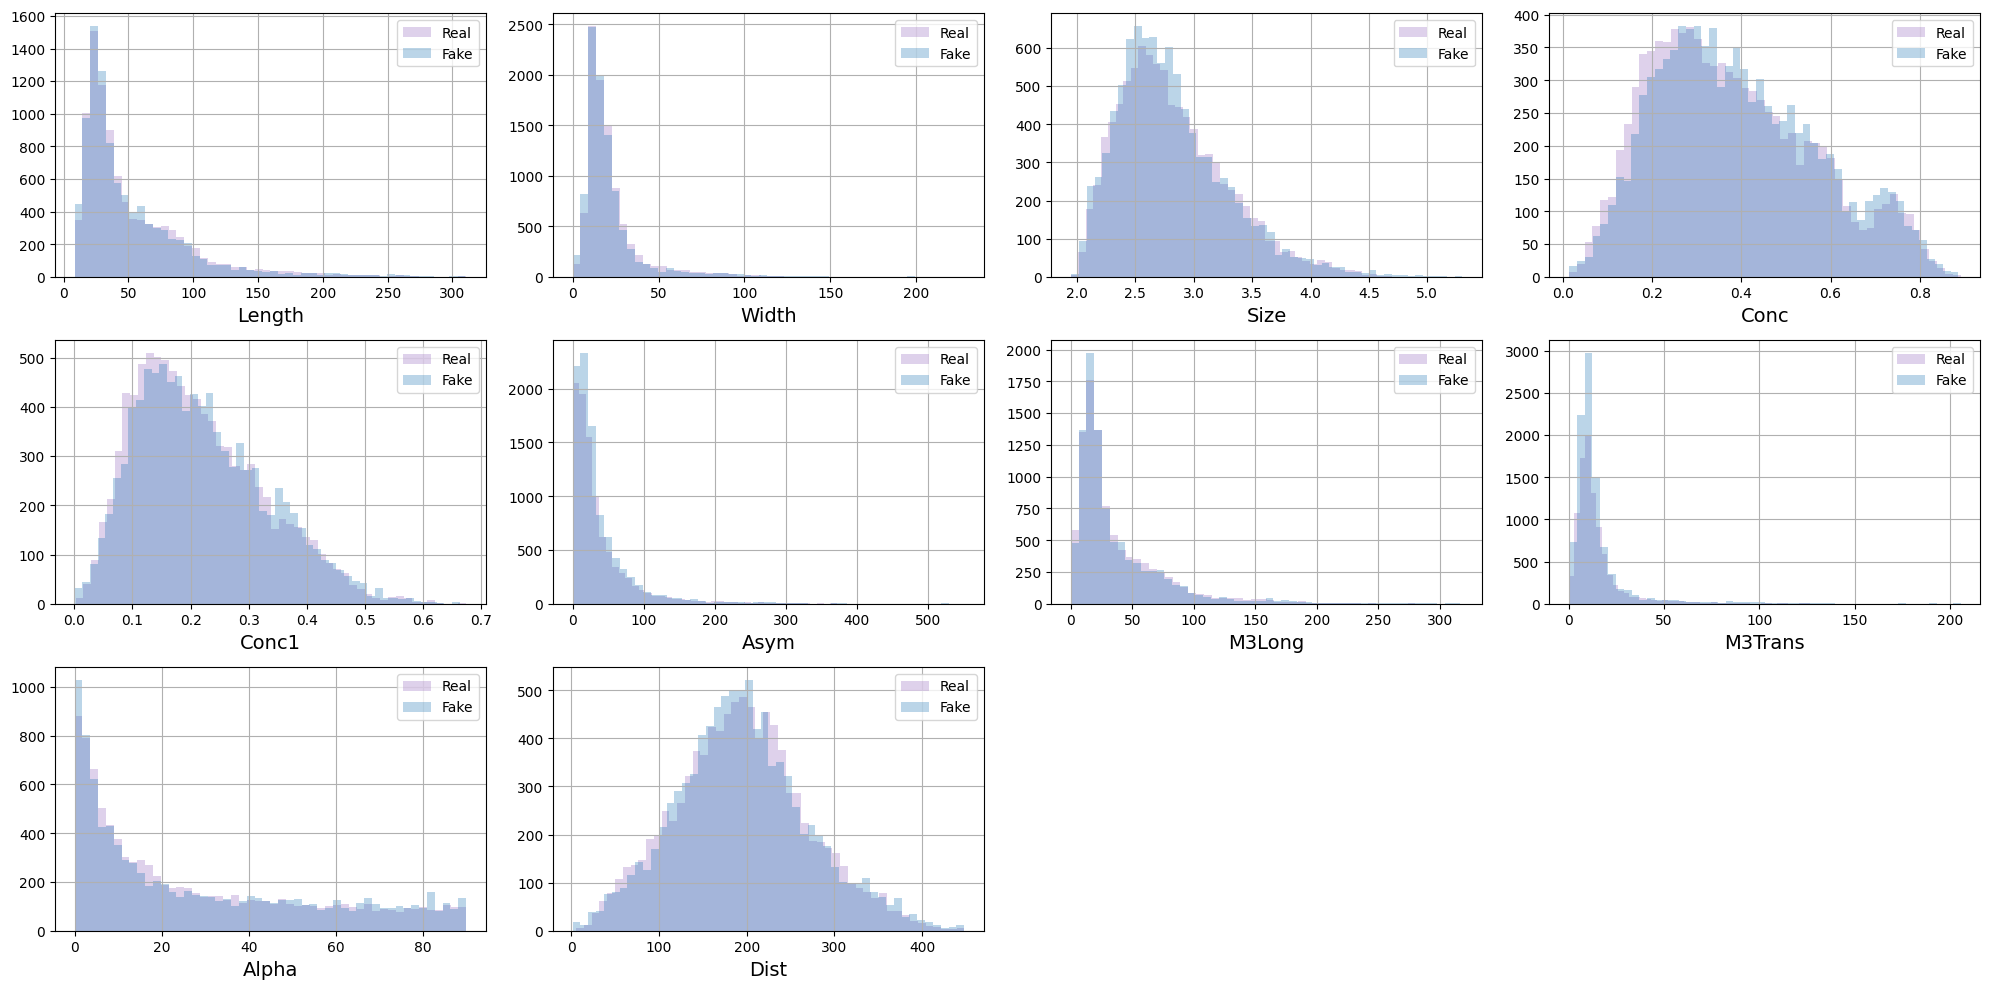

In [29]:
plot_hists(X_test_inv, X_fake_test_inv, names, label1="Real", label2="Fake", bins=50)

## Ответьте на вопросы:
- Похожи ли фейковые объекты на реальные?
- Точно ли хорошая идея сравнивать их на глаз?


**Ответ:** исходя из графиков, фейки и реальные объекты очень похожи. Однако сравнивать модели на глаз не самая лучшая идея, так как мы можем не замечать каких-то важных деталей (очевидно, лучше использовать соответствующие метрики качества).

# Измерение качества генерации

<center><img src="https://github.com/hse-ds/iad-applied-ds/raw/2025/homeworks/HW1/img/clf.png" width="600"></center>

Измерим сходство распределений классификатором.

In [30]:
# собираем реальный и фейковые матрицы в одну
XX_train = np.concatenate((X_fake_train_inv, X_train_inv), axis=0)
XX_test = np.concatenate((X_fake_test_inv, X_test_inv), axis=0)

yy_train = np.array([0] * len(X_fake_train_inv) + [1] * len(X_train_inv))
yy_test = np.array([0] * len(X_fake_test_inv) + [1] * len(X_test_inv))

In [31]:
from sklearn.ensemble import GradientBoostingClassifier

# обучаем классификатор
clf = GradientBoostingClassifier()
clf.fit(XX_train, yy_train)

# получаем прогнозы
yy_test_proba = clf.predict_proba(XX_test)[:, 1]

In [32]:
from sklearn.metrics import roc_auc_score

auc = roc_auc_score(yy_test, yy_test_proba)
print("ROC AUC = ", auc)

ROC AUC =  0.6918865359503141


## Задание 9 (0.5 балла)

Опишите ваш эксперимент. Как вы оцениваете полученные результаты? Как вы думаете, какое значение ROC AUC нас удовлетворяет больше всего? Почему?

**Ответ:** В ходе обучения WGAN-а мною был достигнут результат ROC AUC ≈ 0.7, что является отличным результатом (Цитата Марка: **"Так ну по моим воспоминаниям там как раз где-то 0.6-0.7 для гана норма. 0.9-1 — многовато"**). Действительно, настоящие и фейковые объекты нельзя легко отличить друг от друга (ROC AUC был бы близок к 1), и графики их параметров визуально очень похожи. Конечно, идеальный вариант был бы при ROC AUC = 0.5, что означало бы, что модель классификатора не может отличить фейк от настоящего изображения и вынуждена полагаться на случайное угадывание, но такой результат при использовании ГАНов я считаю почти недостижимым.

## Диффузионные модели.

Давайте теперь проведем такой же экперимент с простой диффузионной моделью.

## Задание 10 (0.5 балла)

Воспользуйтесь [DDPMScheduler](https://huggingface.co/docs/diffusers/api/schedulers/ddpm), возьмите 1000 шагов и подумайте, надо ли указать ещё какой-то параметр.

__Подсказка__: Посмотрите на распределения выше и почитайте описание шедулера в документации. Один из параметров - наследие от использования в генерации картинок, а у нас не картинки.

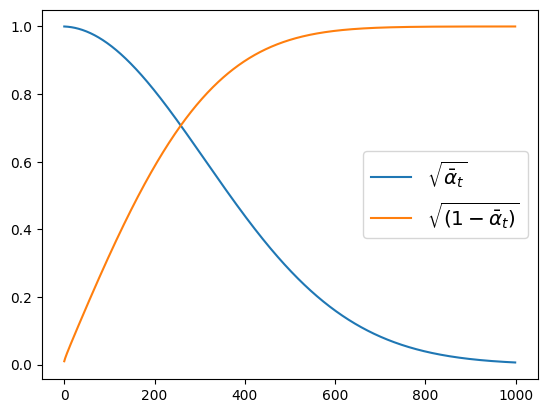

In [33]:
from diffusers import DDPMScheduler

noise_scheduler = DDPMScheduler(clip_sample=False)
plt.plot(
    noise_scheduler.alphas_cumprod.cpu() ** 0.5, label=r"${\sqrt{\bar{\alpha}_t}}$"
)
plt.plot(
    (1 - noise_scheduler.alphas_cumprod.cpu()) ** 0.5,
    label=r"$\sqrt{(1 - \bar{\alpha}_t)}$",
)
plt.legend(fontsize="x-large")

## Задание 11 (0.5 балла)

Реализуйте нейронную сеть. В качестве архитектуры можете взять модель генератора. В процессе экспериментов попробуйте изменять архитектуру модели для улучшения качества сгенерированных объектов (Кстати, как вы будете качество измерять?).

- Полносвязный слой со 100 нейронами;
- Слой батч-нормализации;
- ReLU функцию активации;
- Полносвязный слой со 100 нейронами;
- Слой батч-нормализации;
- ReLU функцию активации;
- Выходной слой.

In [34]:
class DiffusionGenerator(nn.Module):
    def __init__(self, n_inputs, n_outputs):
        super(DiffusionGenerator, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(n_inputs, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(),
            nn.Linear(100, n_outputs),
        )

    def forward(self, z, t, y):

        # Склейте z, t и y при помощи torch.cat
        # Подумайте по какому dim это нужно сделать (в качестве подсказки можете посмотреть документацию Linear)
        # А также о том, что t, скорее всего, одно число, а батч у вас будет большой!
        # Либо предусмотрите раздувание t где-то в другом месте
        zty = torch.cat((z, t, y), dim=1)
        return self.net(zty)

## Задание 12 (0.5 балла)

Напишите функцию для генерации нового объекта с помощью обученной модели.

In [35]:
def generate_with_diffusion(model, y, latent_dim, scheduler):

    # Подсказки: вам понадобится .prev_sample после шага scheduler
    # А ещё цикл по таймстепам
    z = torch.normal(0, 1, (y.shape[0], latent_dim)).to(DEVICE)
    cur_sample = z

    # Цикл по таймстепам (от конца к началу)
    for t in scheduler.timesteps:
        t_batch = torch.tensor(np.full(y.flatten().shape, t), dtype=torch.long).to(DEVICE)  # Изменяем размерность t
        with torch.no_grad():
            gen_sample = model(cur_sample, t_batch.unsqueeze(-1), y)
        cur_sample = scheduler.step(gen_sample, t.item(), cur_sample).prev_sample

    X_fake = cur_sample.detach().cpu().numpy()

    return X_fake  # numpy

## Задание 13 (2 балла)

Напишите класс обучения диффузионной модели и обучите модель, после чего опишите полученные результаты. В качестве подсказки - опирайтесь на семинар по диффузионным моделям. Вы можете изменять некоторые части кода для вашего удобства, но оставляйте в таком случаи комментарии, пожалуйста.

In [36]:
class DiffusionFitter(object):
    def __init__(
        self,
        model,
        noise_scheduler,
        batch_size=32,
        n_epochs=10,
        latent_dim=1,
        lr=0.0001,
        n_critic=5,
    ):

        self.model = model
        self.noise_scheduler = noise_scheduler
        self.batch_size = batch_size
        self.n_epochs = n_epochs
        self.latent_dim = latent_dim
        self.lr = lr
        self.n_critic = n_critic

        self.opt_gen = torch.optim.RMSprop(self.model.parameters(), lr=self.lr)

        self.model.to(DEVICE)

    def fit(self, X, y):

        # numpy to tensor
        X_real = torch.tensor(X, dtype=torch.float, device=DEVICE)
        y_cond = torch.tensor(y, dtype=torch.float, device=DEVICE)

        # tensor to dataset
        dataset_real = TensorDataset(X_real, y_cond)

        # Turn on training
        self.model.train(True)

        self.loss_history = []

        # Fit Diffusion model
        for epoch in range(self.n_epochs):
            loss_epoch = 0
            self.model.train(True)
            for i, (real_batch, cond_batch) in enumerate(
                DataLoader(dataset_real, batch_size=self.batch_size, shuffle=True)
            ):

                ### YOUR CODE IS HERE ######

                # Подсказки:
                # Подумайте какой шум вам тут нужен (uniform/normal?)
                # Помните про scheduler? Как вариант, можете генерировать случайный вектор из integer
                # И подавать его в add_noise и модель

                self.opt_gen.zero_grad()
                noise = torch.randn_like(real_batch)

                timesteps = torch.randint(0, self.noise_scheduler.config.num_train_timesteps, (real_batch.size(0),), device=DEVICE)

                noisy_inputs = self.noise_scheduler.add_noise(real_batch, noise, timesteps)

                model_pred = self.model(noisy_inputs, timesteps.unsqueeze(-1), cond_batch)

                loss = F.mse_loss(model_pred, noise)

                loss.backward()
                self.opt_gen.step()

                loss_epoch += loss.item()

                ### THE END OF YOUR CODE ###

            # caiculate and store loss after an epoch

            self.loss_history.append(loss_epoch / len(dataset_real))

            # Создайте выборку из 1000 объектов из X_train и 1000 сгенерированных объектов
            # И запустите работу фукнции other_agent_score

            ### YOUR CODE IS HERE ######
            if epoch % 10 == 0:
                self.model.train(False)
                X_fake = torch.tensor(generate_with_diffusion(self.model, y_cond, self.latent_dim, self.noise_scheduler))
                num_samples = 1000
                indices = np.random.choice(len(X_real), num_samples)
                other_agent_score(X_real[indices].detach().cpu(), y_cond[indices].detach().cpu(), X_fake[indices].detach().cpu(), y_cond[indices].detach().cpu())
            ### THE END OF YOUR CODE ###

        # Turn off training
        self.model.train(False)

Обучим модель на данных, указав количество входов.

У вас есть скрытое пространство и его размер, есть таймстепы и есть условие. Как легко догадаться, размер входа будет больше, чем просто размер скрытого пространства.

In [37]:
%%time
latent_dim = 10
model = DiffusionGenerator(n_inputs=latent_dim + 1 + y.shape[1], n_outputs=X_train.shape[1])

diffusionFitter = DiffusionFitter(
    model,
    noise_scheduler,
    batch_size=50,
    n_epochs=100,
    latent_dim=latent_dim,
    lr=0.0001,
    n_critic=5,
)
diffusionFitter.fit(X_train, y_train)

Logistic regression score: 0.998
Boosting score: 0.998
Logistic regression score: 0.73
Boosting score: 0.864
Logistic regression score: 0.712
Boosting score: 0.77
Logistic regression score: 0.654
Boosting score: 0.694
Logistic regression score: 0.716
Boosting score: 0.754
Logistic regression score: 0.57
Boosting score: 0.636
Logistic regression score: 0.548
Boosting score: 0.586
Logistic regression score: 0.7
Boosting score: 0.706
Logistic regression score: 0.622
Boosting score: 0.67
Logistic regression score: 0.598
Boosting score: 0.634
CPU times: user 1min 17s, sys: 1.79 s, total: 1min 19s
Wall time: 1min 41s


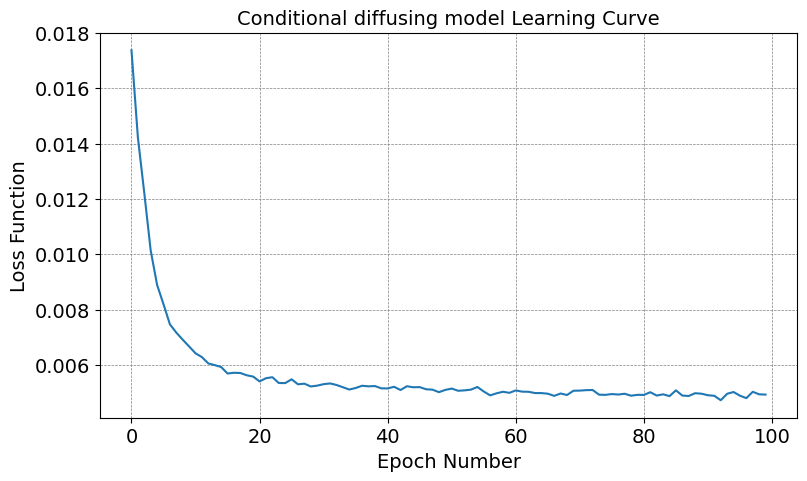

In [38]:
# diffusion learning curve
plt.figure(figsize=(9, 5))
plt.plot(diffusionFitter.loss_history)
plt.xlabel("Epoch Number", size=14)
plt.ylabel("Loss Function", size=14)
plt.xticks(size=14)
plt.yticks(size=14)
plt.title("Conditional diffusing model Learning Curve", size=14)
plt.grid(visible=True, linestyle="--", linewidth=0.5, color="0.5")
plt.show()

## Задание 14 (0.5 балла)
По аналогии с прошлым экспериментом с GAN моделью сгенерируйте выборку фейковых объектов равную размеру тестовой выборки и обучите градиентный бустинг. Обучите модель отличать реальные объекты от фейковых, после чего расчитайте метрики ROC-AUC и accuracy score. Какие получились результаты? Как вы их оцениваете? А в сравнении с GAN моделью?

In [39]:
X_train_inv = qt.inverse_transform(X_train)
X_test_inv = qt.inverse_transform(X_test)

In [40]:
X_fake_train = generate_with_diffusion(diffusionFitter.model, torch.tensor(y_train, dtype=torch.float, device=DEVICE), latent_dim, diffusionFitter.noise_scheduler)
X_fake_train_inv = qt.inverse_transform(X_fake_train)

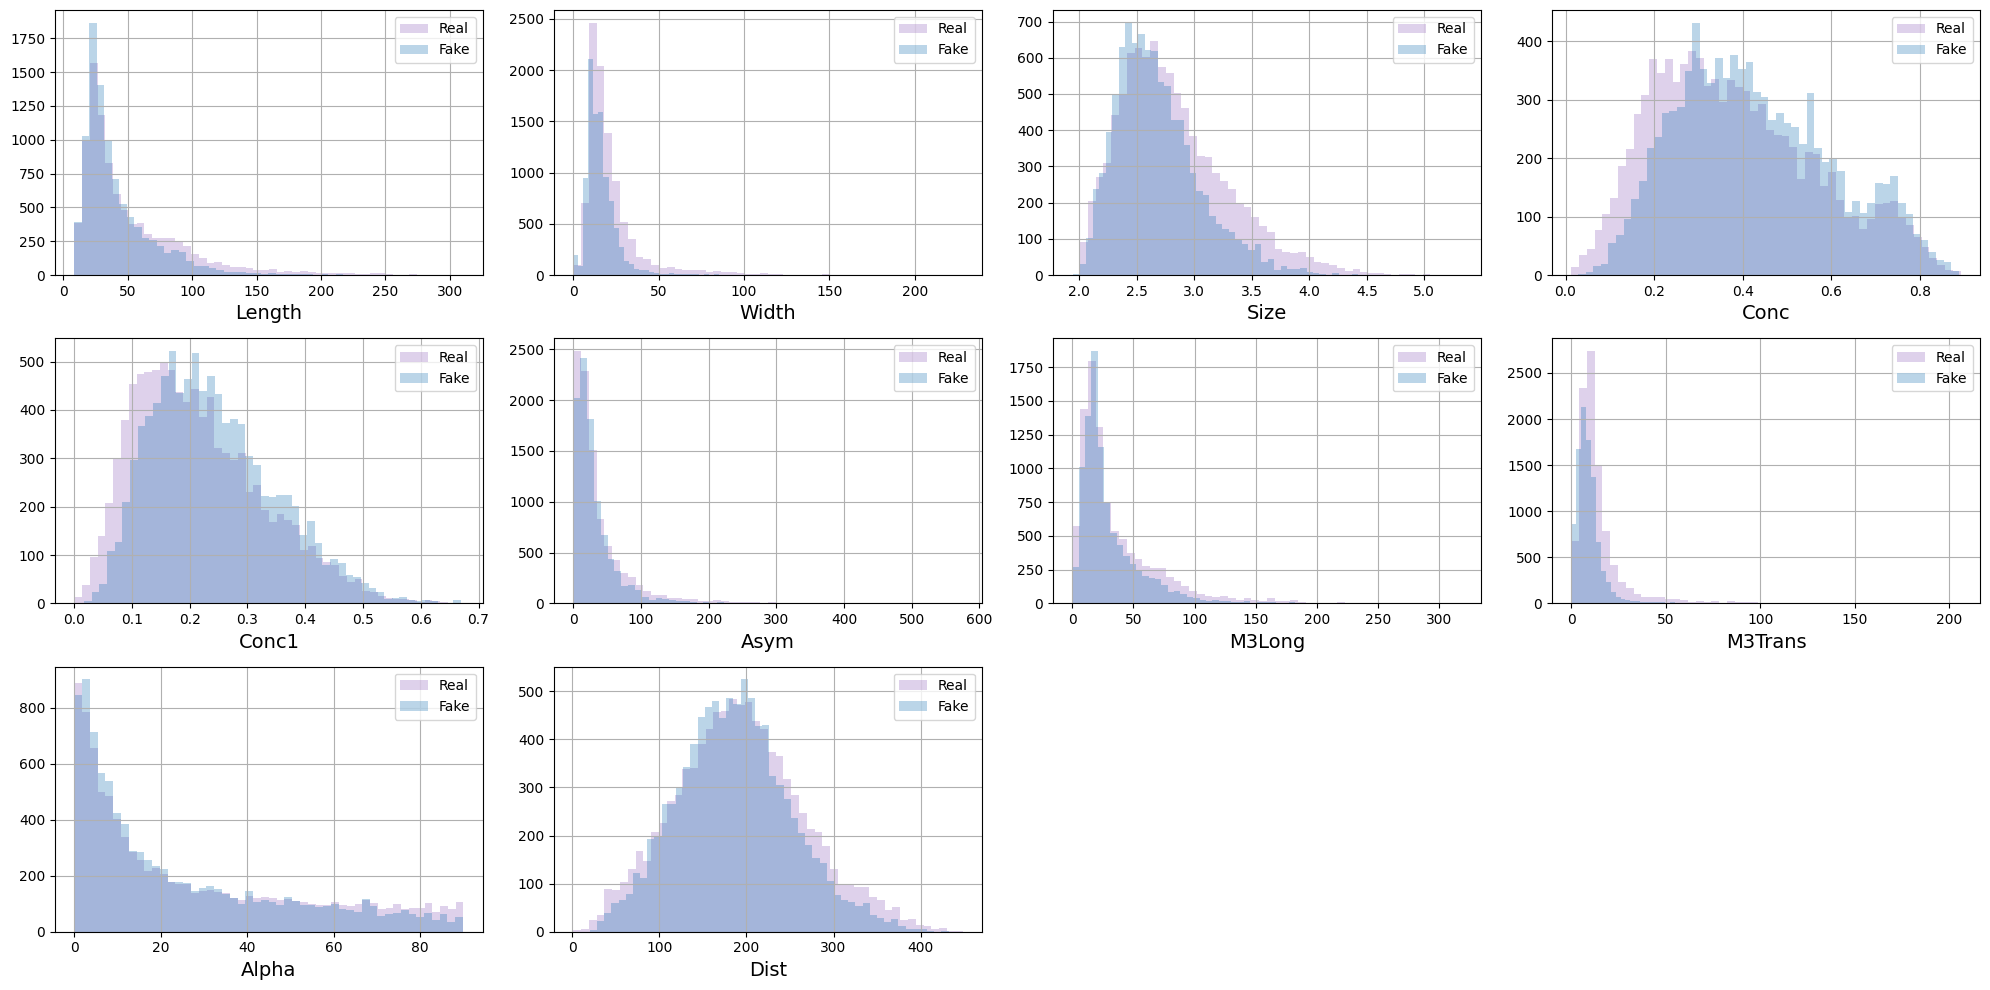

In [41]:
plot_hists(X_train_inv, X_fake_train_inv, names, label1="Real", label2="Fake", bins=50)

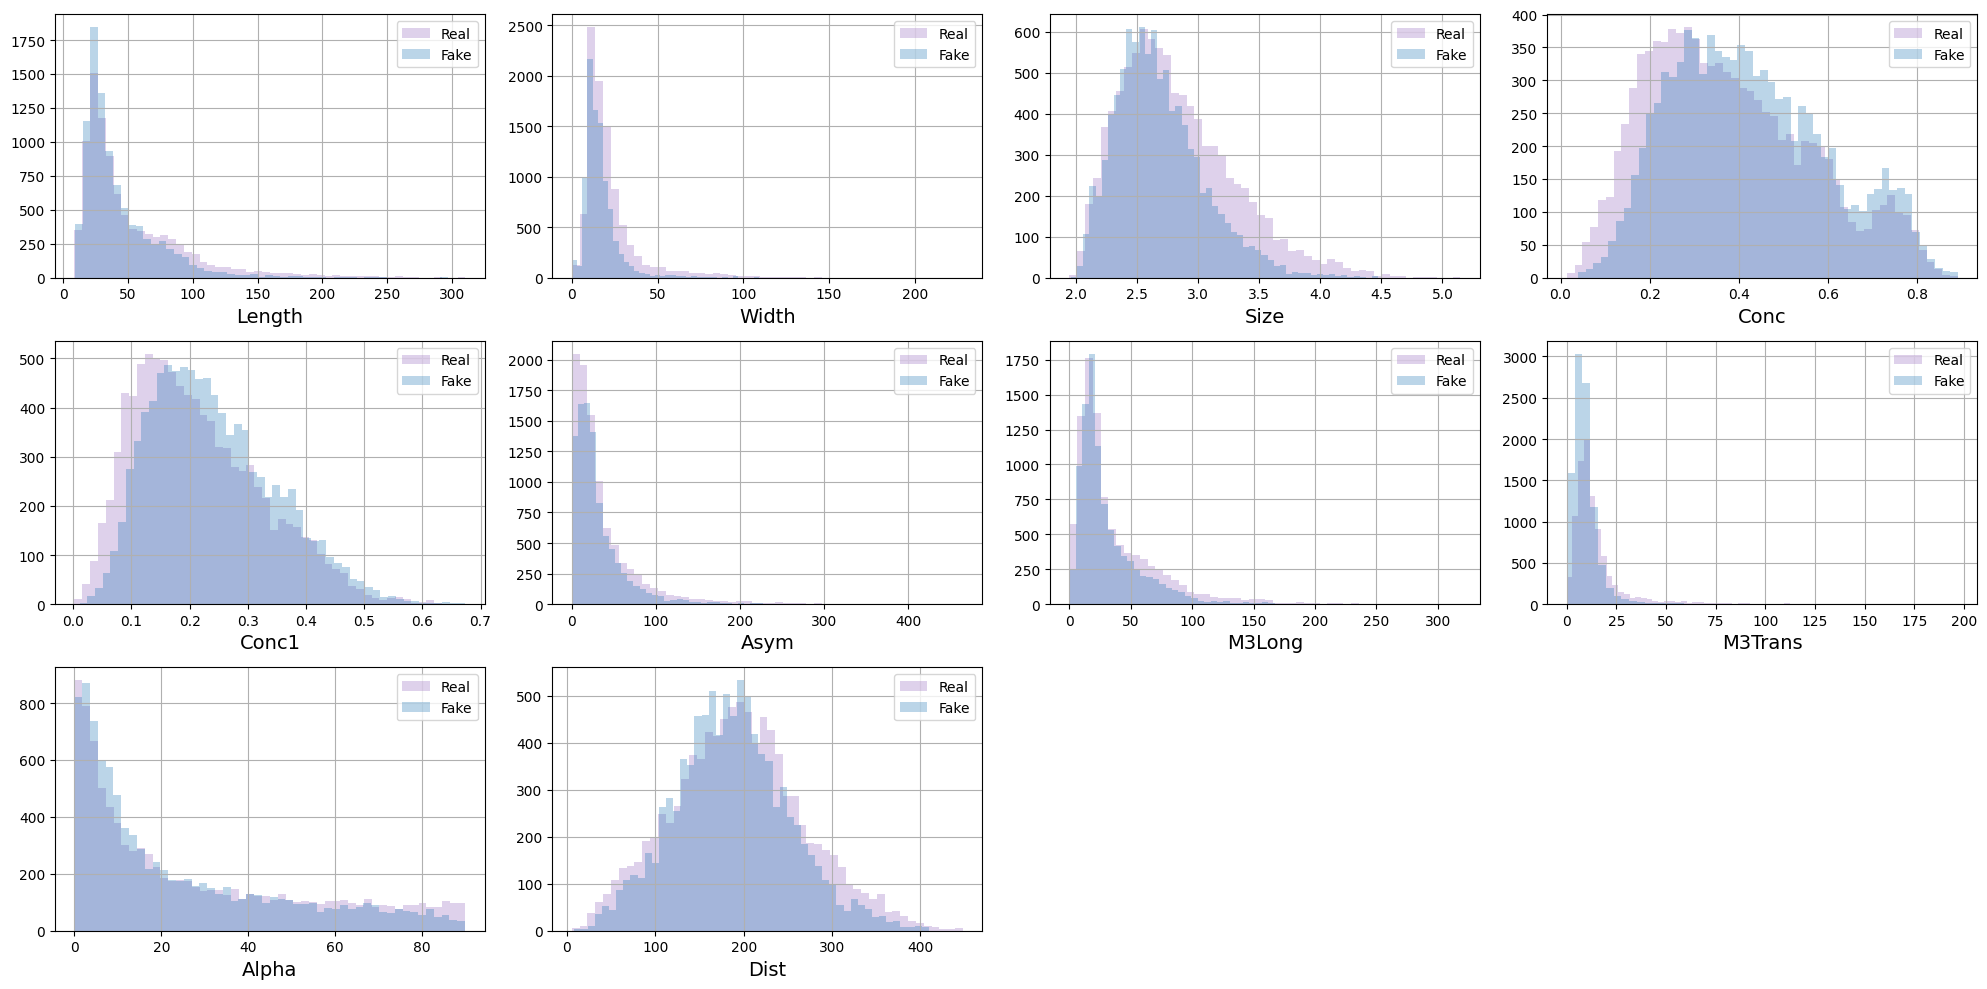

In [42]:
X_fake_test = generate_with_diffusion(diffusionFitter.model, torch.tensor(y_test, dtype=torch.float, device=DEVICE), latent_dim, diffusionFitter.noise_scheduler)
X_fake_test_inv = qt.inverse_transform(X_fake_test)
plot_hists(X_test_inv, X_fake_test_inv, names, label1="Real", label2="Fake", bins=50)

In [43]:
# собираем реальный и фейковые матрицы в одну
XX_train = np.concatenate((X_fake_train_inv, X_train_inv), axis=0)
XX_test = np.concatenate((X_fake_test_inv, X_test_inv), axis=0)

yy_train = np.array([0] * len(X_fake_train_inv) + [1] * len(X_train_inv))
yy_test = np.array([0] * len(X_fake_test_inv) + [1] * len(X_test_inv))

# обучаем классификатор
clf = GradientBoostingClassifier()
clf.fit(XX_train, yy_train)

# получаем прогнозы
yy_test_proba = clf.predict_proba(XX_test)[:, 1]

auc = roc_auc_score(yy_test, yy_test_proba)
print("ROC AUC = ", auc)

ROC AUC =  0.7326169752134285


**Ответ:** В ходе обучения дифузионной модели мною был достигнут результат ROC AUC ≈ 0.75, что является хорошим результатом, но все же уступающий обученному WGAN-у. Графики параметров фейков и реальных объектов для дифузионной модели похожи, но все же имеют визуально более выраженные отличия, чем те же графики для WGAN-а. Конечно, в абсолюте дифузионные модели требуют более сложной архитектуры, чтобы показывать очень хорошие результаты, но в рамках сравнения лоб в лоб с WGAN-ом, дифузионная модель заметно проигрывает.

# Бонус (2 балла)

Кроме Diffusion и GAN вы изучили еще VAE и NF. В качестве бонуса релизуйте VAE, обучите, и в конце сравните качество теми же методами, что и в основной части ДЗ.

Разбалловка бонуса такая:
- Реализовать VAE - 1 балл
- Обучить VAE - 0.5 балла
- Провести сравнение с GAN и Diffusion аналогично 14 заданию основной части - 0.5 балла

Ниже приведены шаблоны. Они не особо щедры на комментарии, но поскольку задача бонусная, ожидаем, что вы в них разберетесь. Если они вам не нравятся - можете переписать как хотите.

Если же VAE вам кажется слишком скучным, то мы засчитаем реализацию NF, но шаблонов не предоставим. Бонус в таком случае тоже ограничен сверху 2 баллами и разбалловка не изменится.

In [44]:
class Encoder(nn.Module):
    def __init__(self, n_inputs, lat_size):
        super(Encoder, self).__init__()

        ### YOUR CODE IS HERE ######
        self.enc_net = nn.Sequential(
            nn.Linear(n_inputs, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(),
            nn.Linear(100, 2 * lat_size),
        )

        self.mu = lambda z: z[:, :lat_size]
        self.log_sigma = lambda z: z[:, lat_size:]
        ### THE END OF YOUR CODE ###

    def forward(self, x, y):
        z = torch.cat((x, y), dim=1)
        z = self.enc_net(z)
        mu = self.mu(z)
        log_sigma = self.log_sigma(z)
        return mu, log_sigma


class Decoder(nn.Module):
    def __init__(self, n_inputs, n_outputs):
        super(Decoder, self).__init__()

        ### YOUR CODE IS HERE ######
        self.dec_net = nn.Sequential(
            nn.Linear(n_inputs, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(),
            nn.Linear(100, n_outputs),
        )
        ### THE END OF YOUR CODE ###

    def forward(self, z, y):
        z_cond = torch.cat((z, y), dim=1)
        x_rec = self.dec_net(z_cond)
        return x_rec

def generate(decoder, y, latent_dim):
    ### YOUR CODE IS HERE ######
    z = torch.normal(0, 1, (y.shape[0], latent_dim)).to(DEVICE)
    X_fake = decoder(z, y)
    ### THE END OF YOUR CODE ###
    return X_fake.detach().cpu().numpy()  # numpy

In [65]:
class VAEFitter(object):
    def __init__(
        self,
        encoder,
        decoder,
        batch_size=32,
        n_epochs=10,
        latent_dim=1,
        lr=0.0001,
        KL_weight=0.001,
    ):

        self.encoder = encoder
        self.decoder = decoder
        self.batch_size = batch_size
        self.n_epochs = n_epochs
        self.latent_dim = latent_dim
        self.lr = lr
        self.KL_weight = KL_weight

        self.criterion = nn.MSELoss()
        self.opt = torch.optim.RMSprop(
            list(self.encoder.parameters()) + list(self.decoder.parameters()),
            lr=self.lr,
        )

        self.encoder.to(DEVICE)
        self.decoder.to(DEVICE)

    def sample_z(self, mu, log_sigma):
        eps = torch.randn(mu.shape).to(DEVICE)
        return mu + torch.exp(log_sigma / 2) * eps

    def custom_loss(self, x, rec_x, mu, log_sigma):
        KL = torch.mean(
            -0.5 * torch.sum(1 + log_sigma - mu**2 - log_sigma.exp(), dim=1), dim=0
        )
        recon_loss = self.criterion(x, rec_x)
        return KL * self.KL_weight + recon_loss

    def compute_loss(self, x_batch, cond_batch):

        ### YOUR CODE IS HERE ######
        mu, log_sigma = self.encoder(x_batch, cond_batch)
        z = self.sample_z(mu, log_sigma)

        rec_x = self.decoder(z, cond_batch)

        loss = self.custom_loss(x_batch, rec_x, mu, log_sigma)
        ### THE END OF YOUR CODE ###

        return loss

    def fit(self, X, y):

        # numpy to tensor
        X_real = torch.tensor(X, dtype=torch.float, device=DEVICE)
        y_cond = torch.tensor(y, dtype=torch.float, device=DEVICE)

        # tensor to dataset
        dataset_real = TensorDataset(X_real, y_cond)

        # Turn on training
        self.encoder.train(True)
        self.decoder.train(True)

        self.loss_history = []

        # Fit
        for epoch in range(self.n_epochs):
            for i, (x_batch, cond_batch) in enumerate(
                DataLoader(dataset_real, batch_size=self.batch_size, shuffle=True)
            ):

                # caiculate loss
                loss = self.compute_loss(x_batch, cond_batch)

                # optimization step
                self.opt.zero_grad()
                loss.backward()
                self.opt.step()

            # caiculate and store loss after an epoch
            loss_epoch = self.compute_loss(X_real, y_cond)
            self.loss_history.append(loss_epoch.detach().cpu())

        # Turn off training
        self.encoder.train(False)
        self.decoder.train(False)

In [66]:
%%time
latent_dim = 10
encoder = Encoder(n_inputs=latent_dim + y.shape[1], lat_size=latent_dim)
decoder = Decoder(n_inputs=latent_dim + y.shape[1], n_outputs=X_train.shape[1])

vaeFitter = VAEFitter(
    encoder,
    decoder,
    batch_size=50,
    n_epochs=100,
    latent_dim=latent_dim,
    lr=0.0001,
    KL_weight=0.001,
)
vaeFitter.fit(X_train, y_train)

CPU times: user 1min 16s, sys: 1.08 s, total: 1min 17s
Wall time: 1min 20s


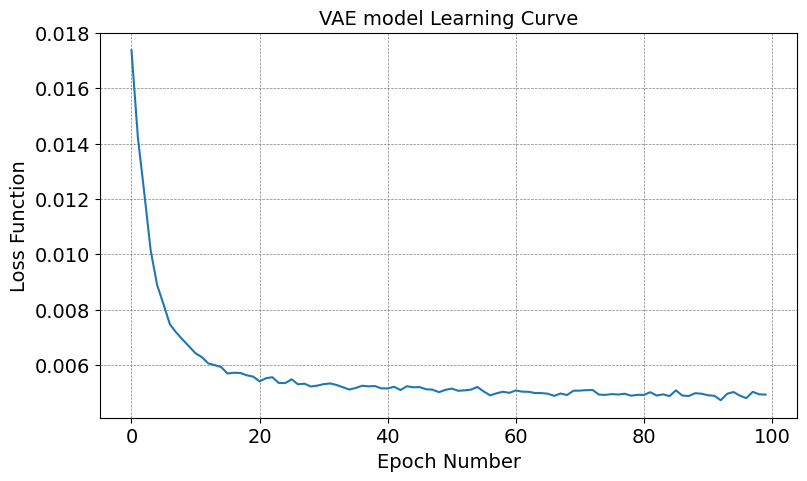

In [67]:
# diffusion learning curve
plt.figure(figsize=(9, 5))
plt.plot(diffusionFitter.loss_history)
plt.xlabel("Epoch Number", size=14)
plt.ylabel("Loss Function", size=14)
plt.xticks(size=14)
plt.yticks(size=14)
plt.title("VAE model Learning Curve", size=14)
plt.grid(visible=True, linestyle="--", linewidth=0.5, color="0.5")
plt.show()

In [68]:
X_train_inv = qt.inverse_transform(X_train)
X_test_inv = qt.inverse_transform(X_test)

In [69]:
X_fake_train = generate(vaeFitter.decoder, torch.tensor(y_train, dtype=torch.float, device=DEVICE), latent_dim)
X_fake_train_inv = qt.inverse_transform(X_fake_train)

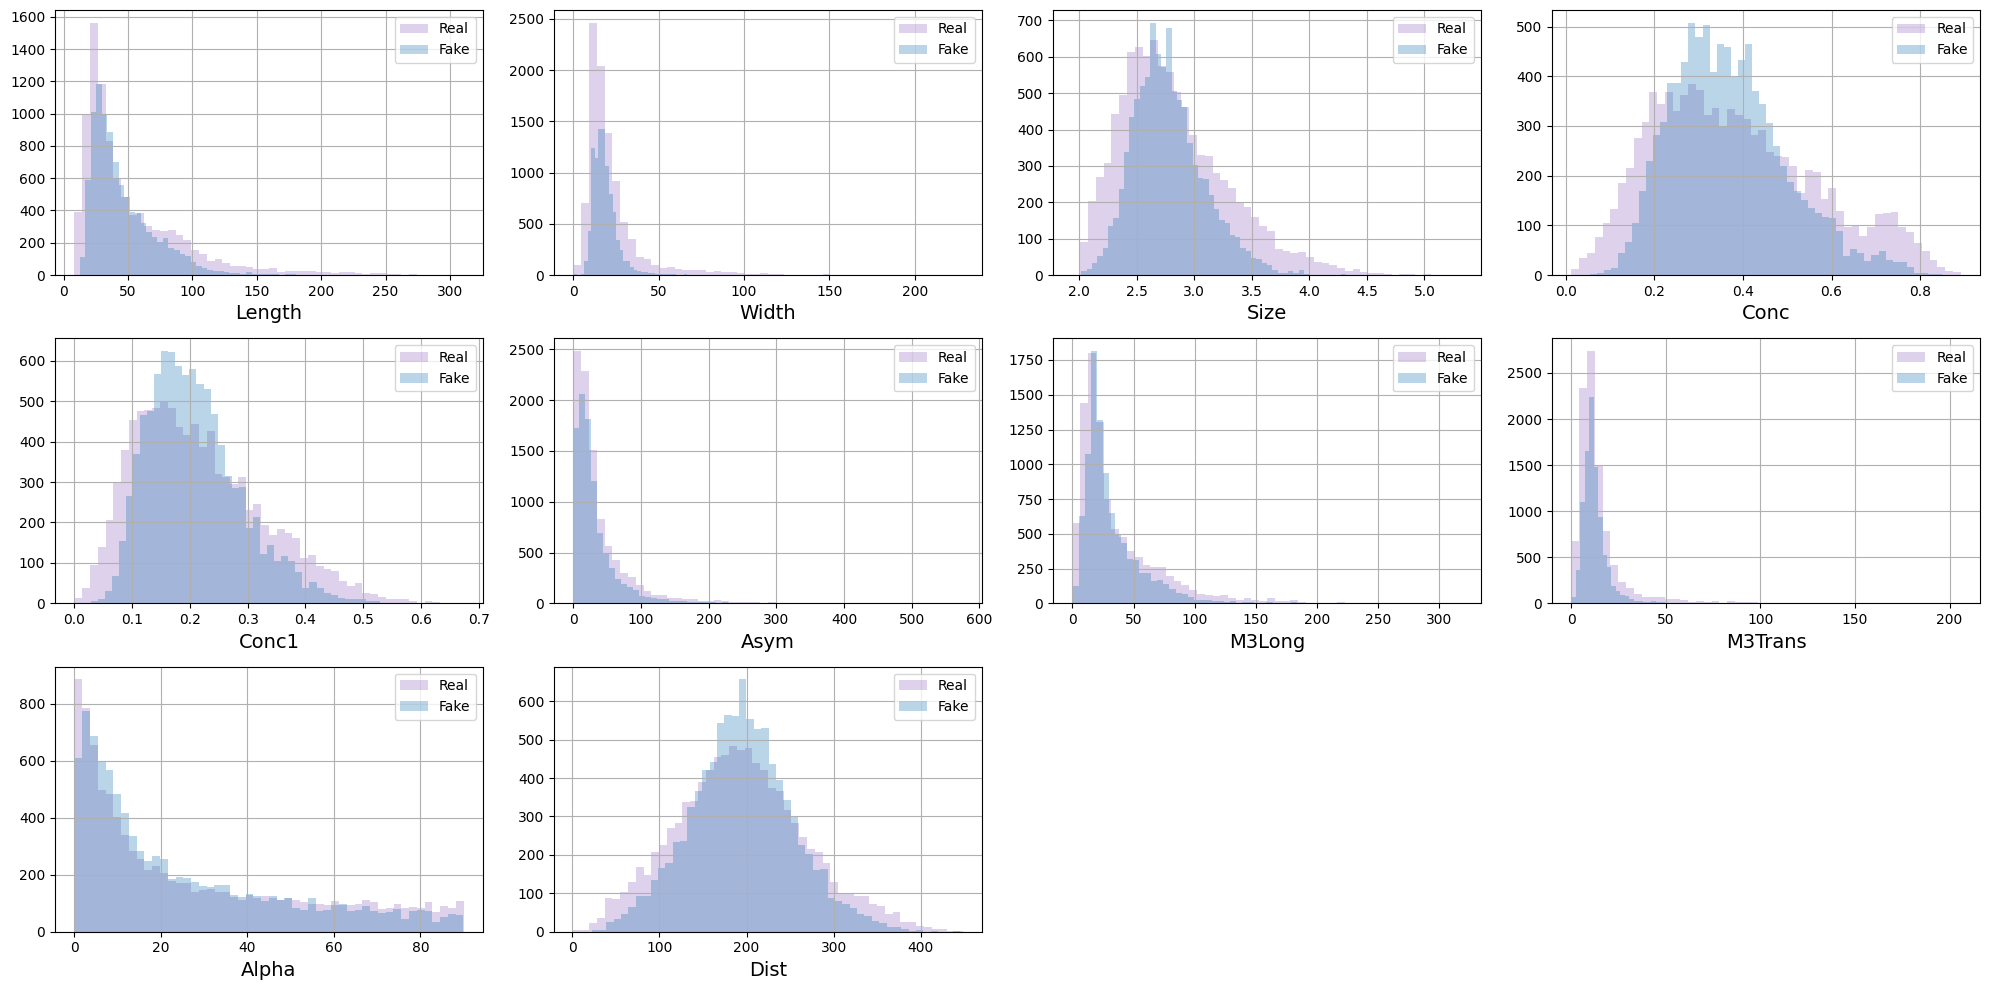

In [70]:
plot_hists(X_train_inv, X_fake_train_inv, names, label1="Real", label2="Fake", bins=50)

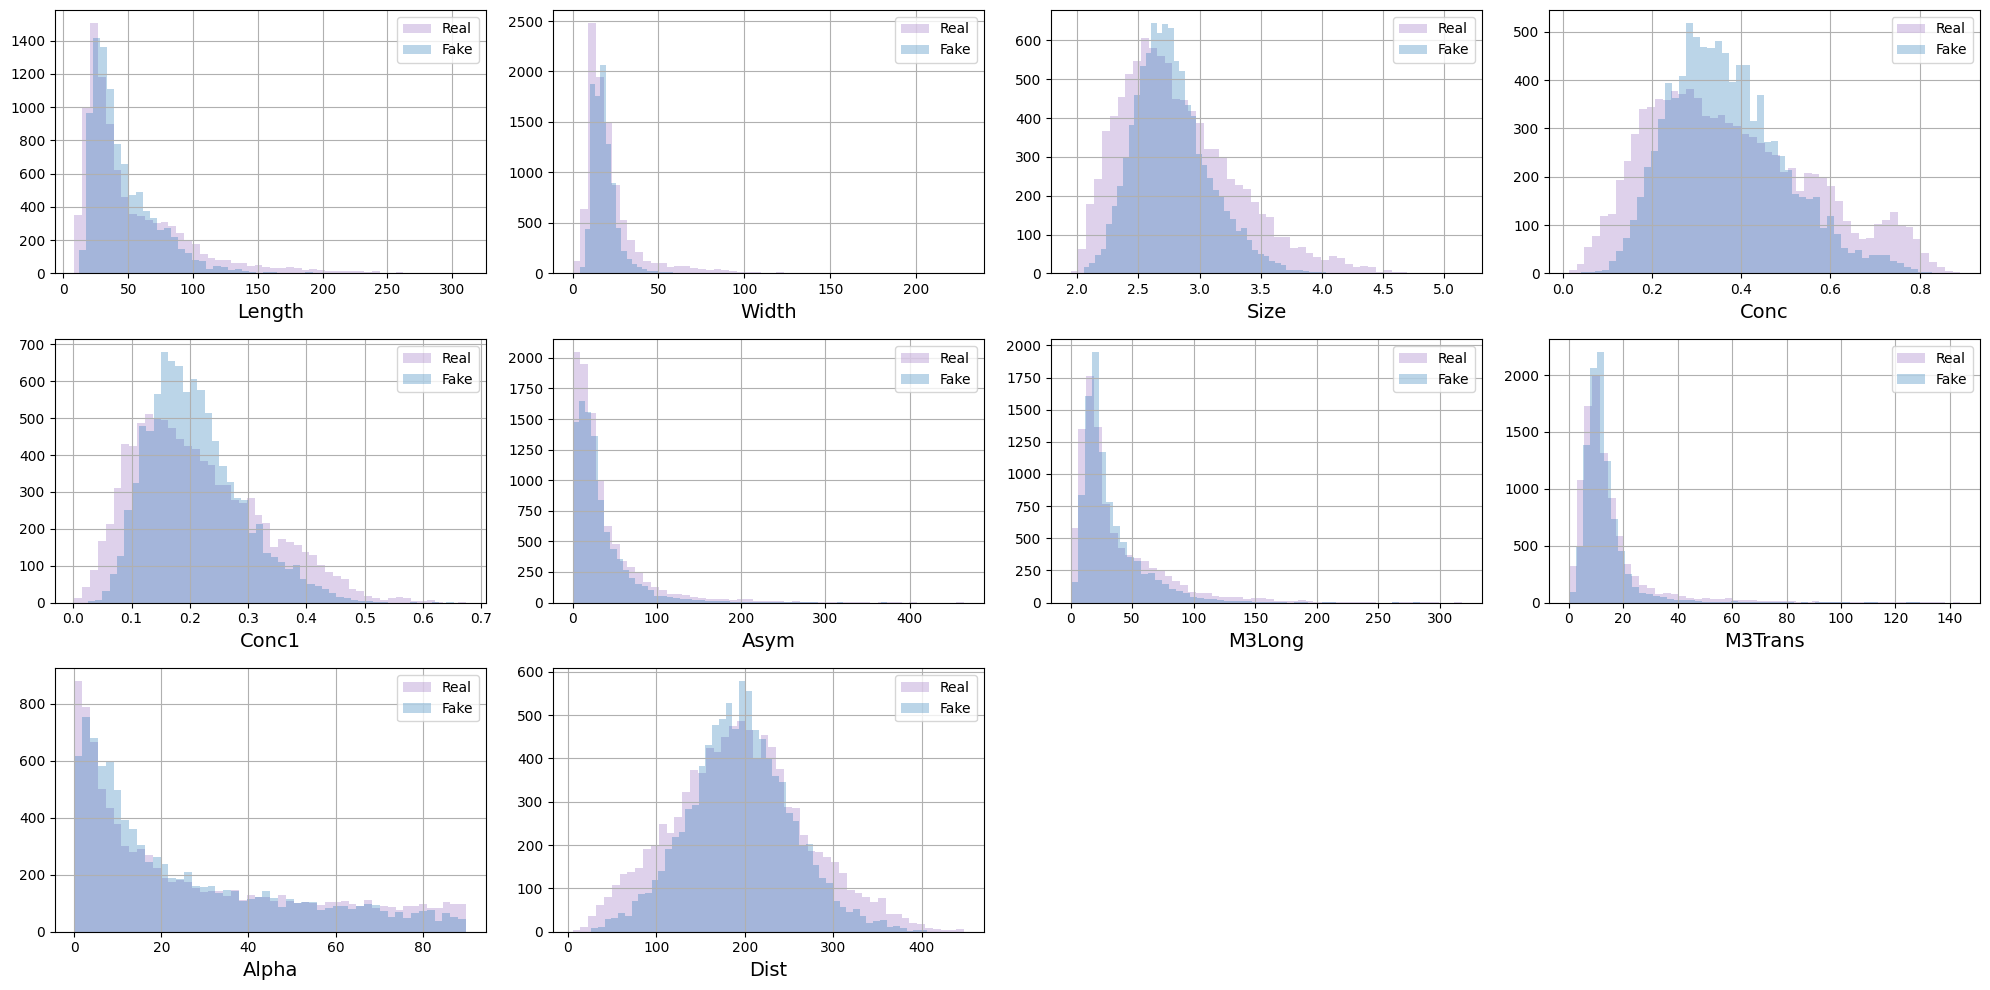

In [71]:
X_fake_test = generate(vaeFitter.decoder, torch.tensor(y_test, dtype=torch.float, device=DEVICE), latent_dim)
X_fake_test_inv = qt.inverse_transform(X_fake_test)
plot_hists(X_test_inv, X_fake_test_inv, names, label1="Real", label2="Fake", bins=50)

In [72]:
# собираем реальный и фейковые матрицы в одну
XX_train = np.concatenate((X_fake_train_inv, X_train_inv), axis=0)
XX_test = np.concatenate((X_fake_test_inv, X_test_inv), axis=0)

yy_train = np.array([0] * len(X_fake_train_inv) + [1] * len(X_train_inv))
yy_test = np.array([0] * len(X_fake_test_inv) + [1] * len(X_test_inv))

# обучаем классификатор
clf = GradientBoostingClassifier()
clf.fit(XX_train, yy_train)

# получаем прогнозы
yy_test_proba = clf.predict_proba(XX_test)[:, 1]

auc = roc_auc_score(yy_test, yy_test_proba)
print("ROC AUC = ", auc)

ROC AUC =  0.7717264465651852


**Ответ:** В ходе обучения VAE мною был достигнут результат ROC AUC ≈ 0.77, что является хорошим результатом, но худшим в сравнении с теми же WGAN-ом и дифузионной моделью. Графики параметров фейков и реальных объектов для дифузионной модели уже имеют видимые отличия, хотя общий вид похож. В принципе, этот результат логичен, так как обычная VAE модель должна быть хуже обычного WGAN-а по качеству сгенерированных изображений.

## Отзыв

Поздравляю! Вы дошли до конца. Оставьте ваш отзыв ячейкой ниже или отправьте его в канал курса, нам будет очень интересно!

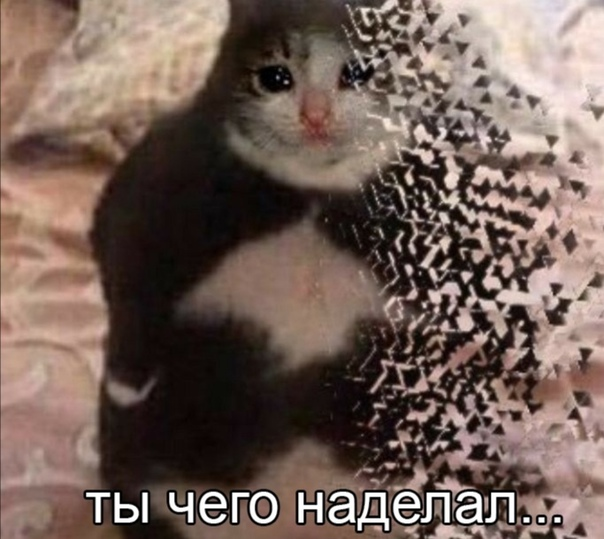